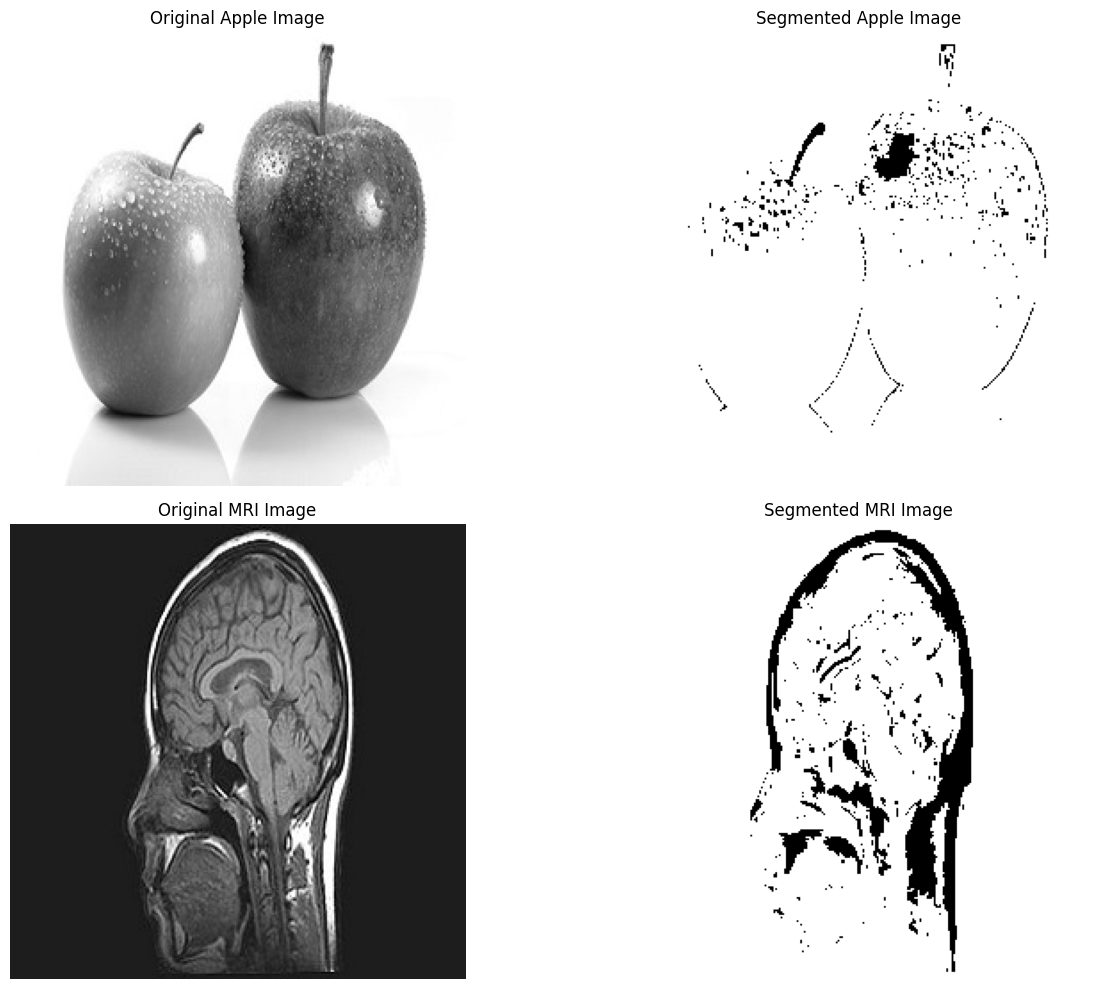

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

apple_image_path = "apple.jpg"
mri_image_path = "mri.jpg"


def region_growing(img, seed):
    height, width = img.shape
    visited = np.zeros_like(img, dtype=np.uint8)
    output = np.zeros_like(img, dtype=np.uint8)
    threshold = 20
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    stack = [seed]

    while stack:
        x, y = stack.pop()

        if visited[y, x] == 1:
            continue

        visited[y, x] = 1
        output[y, x] = 255

        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < width and 0 <= ny < height:
                diff = abs(int(img[y, x]) - int(img[ny, nx]))
                if diff < threshold and visited[ny, nx] == 0:
                    stack.append((nx, ny))

    return output


apple_img = cv2.imread(apple_image_path, cv2.IMREAD_GRAYSCALE)
seed_apple = (apple_img.shape[1] // 2, apple_img.shape[0] // 2)
segmented_apple = region_growing(apple_img, seed_apple)

mri_img = cv2.imread(mri_image_path, cv2.IMREAD_GRAYSCALE)
seed_mri = (mri_img.shape[1] // 2, mri_img.shape[0] // 2)
segmented_mri = region_growing(mri_img, seed_mri)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].imshow(apple_img, cmap='gray')
axes[0, 0].set_title('Original Apple Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(segmented_apple, cmap='gray')
axes[0, 1].set_title('Segmented Apple Image')
axes[0, 1].axis('off')

axes[1, 0].imshow(mri_img, cmap='gray')
axes[1, 0].set_title('Original MRI Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(segmented_mri, cmap='gray')
axes[1, 1].set_title('Segmented MRI Image')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

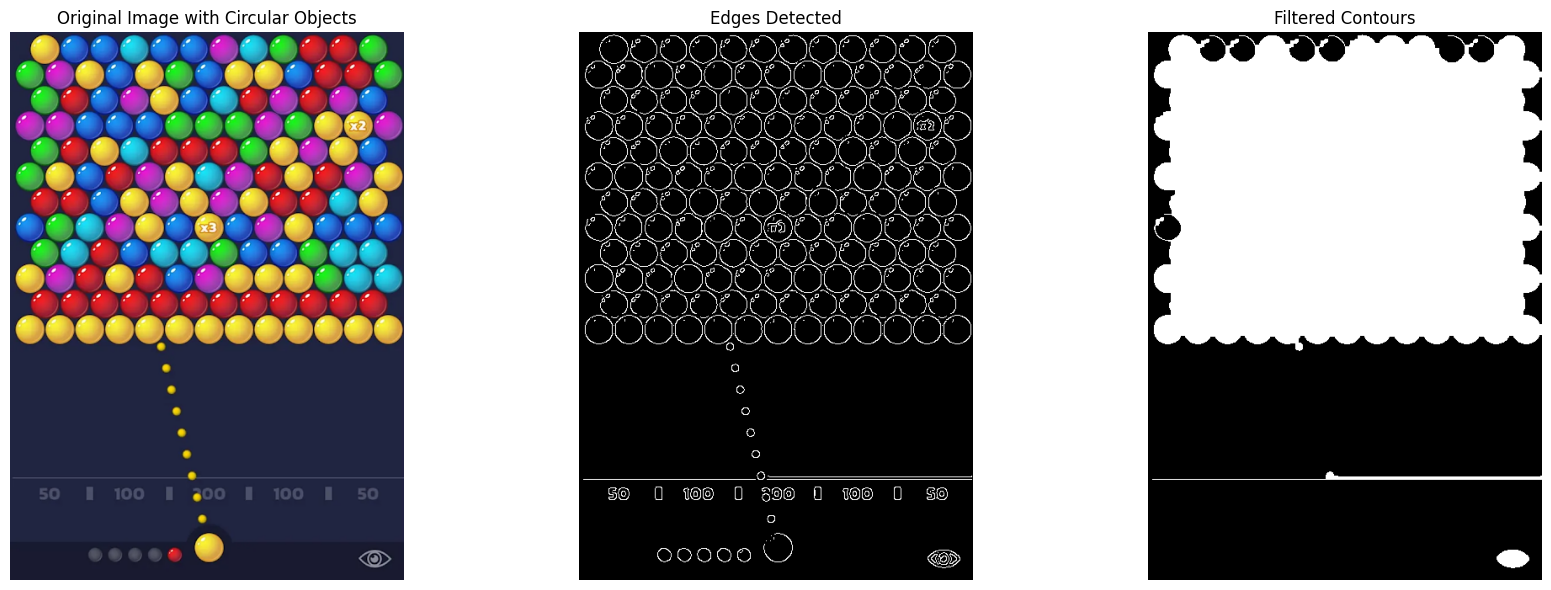

In [ ]:
kmeans_image_path = 'practica2.1_kmeans_2.png'

kmeans_example_img = cv2.imread(kmeans_image_path, cv2.IMREAD_COLOR)
kmeans_example_img_gray = cv2.cvtColor(kmeans_example_img, cv2.COLOR_BGR2GRAY)


def filtro_canny(imagen, umbral_bajo=50, umbral_alto=400):
    # Cargar la imagen

    # Aplicar el filtro Gaussiano para reducir el ruido
    imagen_suavizada = cv2.GaussianBlur(imagen, (5, 5), 1.4)

    # Calcular los gradientes utilizando los kernels de Sobel
    Ix = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 0, 1, ksize=3)

    # Calcular la magnitud y el ángulo del gradiente
    magnitud_gradiente = np.sqrt(Ix**2 + Iy**2)
    angulo_gradiente = np.arctan2(Iy, Ix)

    # Supresión no máxima
    imagen_suprimida = np.zeros_like(magnitud_gradiente)
    angulo_gradiente = angulo_gradiente * 180.0 / np.pi
    angulo_gradiente[angulo_gradiente < 0] += 180

    for i in range(1, imagen.shape[0] - 1):
        for j in range(1, imagen.shape[1] - 1):
            angulo = angulo_gradiente[i, j]
            if (0 <= angulo < 22.5) or (157.5 <= angulo <= 180):
                vecinos = [magnitud_gradiente[i, j - 1], magnitud_gradiente[i, j + 1]]
            elif 22.5 <= angulo < 67.5:
                vecinos = [magnitud_gradiente[i - 1, j - 1], magnitud_gradiente[i + 1, j + 1]]
            elif 67.5 <= angulo < 112.5:
                vecinos = [magnitud_gradiente[i - 1, j], magnitud_gradiente[i + 1, j]]
            else:
                vecinos = [magnitud_gradiente[i - 1, j + 1], magnitud_gradiente[i + 1, j - 1]]

            if magnitud_gradiente[i, j] >= max(vecinos):
                imagen_suprimida[i, j] = magnitud_gradiente[i, j]

    # Doble umbral
    imagen_umbral = np.zeros_like(imagen_suprimida)
    imagen_umbral[(imagen_suprimida >= umbral_bajo) & (imagen_suprimida <= umbral_alto)] = 255

    return imagen_umbral




edges = filtro_canny(kmeans_example_img_gray)

kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

closing = cv2.convertScaleAbs(closing)
contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_area = 500
filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_area]

contour_img = np.zeros_like(kmeans_example_img_gray)
cv2.drawContours(contour_img, filtered_contours, -1, (255), thickness=-1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(kmeans_example_img, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image with Circular Objects')
axes[0].axis('off')

axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Edges Detected')
axes[1].axis('off')

axes[2].imshow(contour_img, cmap='gray')
axes[2].set_title('Filtered Contours')
axes[2].axis('off')

plt.tight_layout()
plt.show()


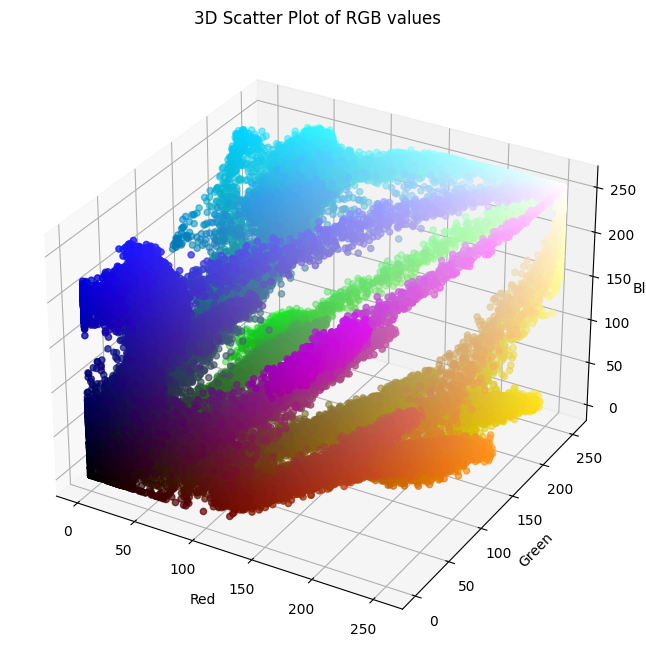

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pixels = kmeans_example_img.reshape((-1, 3))

pixels = np.float32(pixels)

r = pixels[:, 0]
g = pixels[:, 1]
b = pixels[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r, g, b, c=pixels / 255.0)

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('3D Scatter Plot of RGB values')

plt.show()

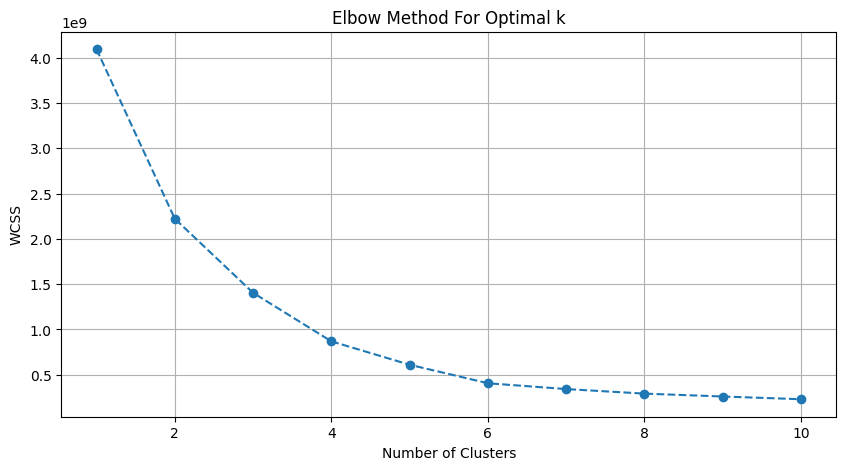

In [45]:
from sklearn.cluster import KMeans

wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pixels)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

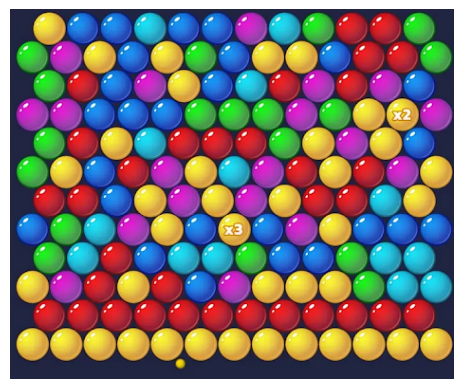

In [46]:
def compute_edge_density(edge_image):
    """Compute the density of edges in the given image."""
    return np.sum(edge_image) / (edge_image.shape[0] * edge_image.shape[1])

num_regions = 10
region_height = edges.shape[0] // num_regions
densities = []

for i in range(num_regions):
    start_row = i * region_height
    end_row = (i + 1) * region_height
    region = edges[start_row:end_row, :]
    densities.append(compute_edge_density(region))

threshold = np.mean(densities)

valid_regions = [i for i, density in enumerate(densities) if density > threshold]

y_min = valid_regions[0] * region_height
y_max = (valid_regions[-1] + 1) * region_height
cropped_image = kmeans_example_img[y_min:y_max, :]

plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


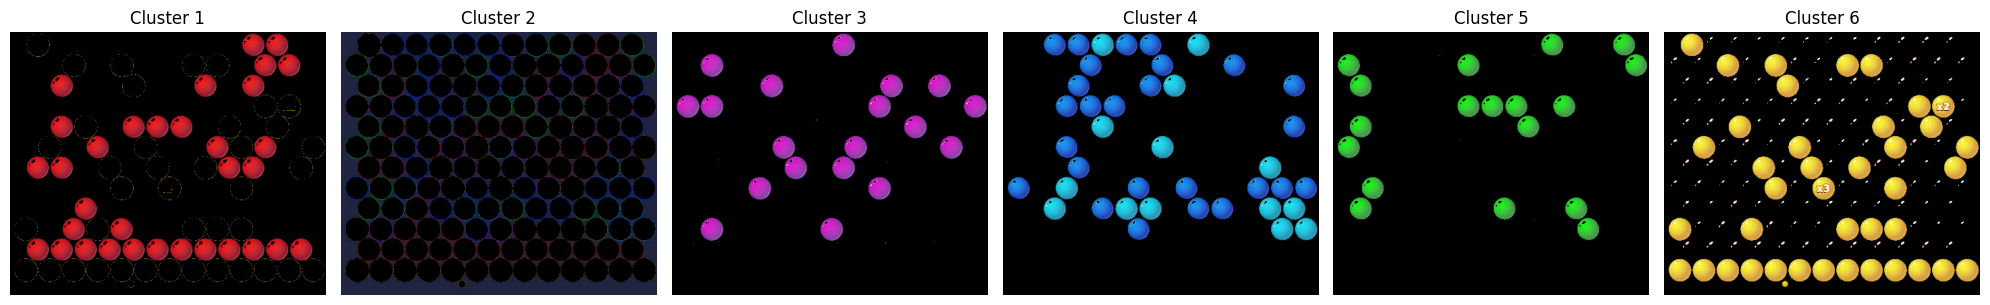

In [47]:
def apply_kmeans_opencv_modified(image, n_clusters):
    """Apply KMeans clustering using OpenCV and return the labeled image."""
    pixels = image.reshape(-1, 3)
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, _ = cv2.kmeans(pixels, n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    labeled_image = labels.reshape(image.shape[:2])
    return labeled_image

filtered_kmeans_img_modified = cv2.bitwise_and(cropped_image, cropped_image)

k = 6

labeled_image_opencv_modified = apply_kmeans_opencv_modified(filtered_kmeans_img_modified, k)

fig, axes = plt.subplots(1, k, figsize=(20, 5))

for i in range(k):
    cluster_img = np.zeros_like(cropped_image)
    cluster_img[labeled_image_opencv_modified == i] = cropped_image[labeled_image_opencv_modified == i]
    axes[i].imshow(cv2.cvtColor(cluster_img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Cluster {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()